Ссылка на оригинальный блокнотик -
https://colab.research.google.com/drive/1RnoApBviiU7RVQmu8vaA_BrE7TJtAAkp?usp=sharing


In [99]:
import time
from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import scipy

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from scipy.stats import normaltest, skew, kurtosis
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [100]:
root = 'drive/MyDrive/ml/lab1/'
data = pd.read_csv(root+'train.csv')
testdata = pd.read_csv(root+'test.csv')
data

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11012,2010-07-10,57.0,300000.0,850.0,14756.0,48.0,Married,2.0,Own,620.0,...,Employed,Associate,38.0,167544.0,0.094756,0.106387,378.792448,0.039952,1.0,32.440586
11013,2003-10-22,28.0,15000.0,300.0,51361.0,96.0,Single,1.0,Own,696.0,...,Employed,Bachelor,5.0,116879.0,0.446361,0.401087,1793.042130,1.991234,0.0,67.673170
11014,1983-05-12,23.0,15000.0,302.0,30724.0,72.0,Married,3.0,Rent,413.0,...,Self-Employed,Associate,0.0,250778.0,0.404724,0.360670,1047.672294,1.168538,0.0,75.292707
11015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
# Работа с датасетом
---

## Пропуски в датасете

In [101]:
def build_distribution(values, column):
  sns.kdeplot(values, fill=True, cut=0)
  plt.plot([values.mean(), values.mean()], [0, np.max(plt.yticks()[0])], label='Средее')
  plt.scatter([], [], alpha=0, label=f'Асимметрия: {scipy.stats.skew(values):.3f}')
  plt.scatter([], [], alpha=0, label=f'Эксцесс: {scipy.stats.kurtosis(values):.3f}')
  plt.title(f'Плотность {column}')
  plt.legend()

def show_distribution(df, column):
  plt.figure(figsize=(20, 5))
  plt.subplot(1, 2, 1)
  build_distribution(df[column], column)
  plt.subplot(1, 2, 2)
  plt.boxplot(df[column], tick_labels=[column])
  plt.title(f'Разброс {column}')
  plt.show()

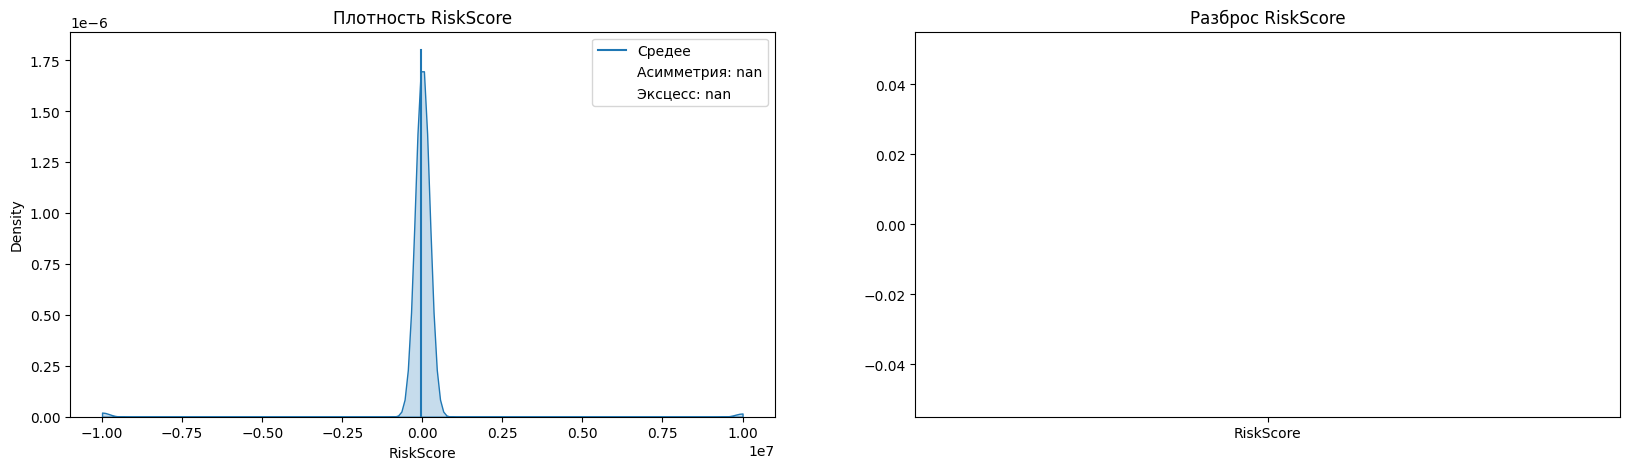

In [102]:
show_distribution(data, 'RiskScore')

In [103]:
data['RiskScore'].isna().agg({'NA count': 'sum'})

,RiskScore
NA count,530


 ---
 ---
Удалим все строки с пропусками в RiskScore

In [104]:
data = data.dropna(subset=['RiskScore'], axis='rows')
data['RiskScore'].isna().agg({'NA count': 'sum'})

,RiskScore
NA count,0


 ---
 ---
Однако в других признаках все еще остались пропуски

In [105]:
pd.DataFrame({'Пропуски в признаке': data.isna().sum()})

,Пропуски в признаке
ApplicationDate,0
Age,0
AnnualIncome,0
CreditScore,501
LoanAmount,501
LoanDuration,0
MaritalStatus,0
NumberOfDependents,0
HomeOwnershipStatus,0
MonthlyDebtPayments,501


 ---
 ---
Обработаем отдельно для числовых и категориальных признаков

## Числовые признаки

In [106]:
numeric_features = data.drop(columns='RiskScore').select_dtypes(np.number).columns
numeric_features

Index(['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
       'NumberOfDependents', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
       'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory',
       'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate',
       'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio',
       'LoanApproved'],
      dtype='object')

 ---
 ---
Для числовых признаков заменим на среднее

In [107]:
data.loc[:,numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

## Категориальные признаки

In [108]:
categorical_features = data.drop(columns='RiskScore').select_dtypes(object).columns
categorical_features

Index(['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus',
       'LoanPurpose', 'EmploymentStatus', 'EducationLevel'],
      dtype='object')

 ---
 ---
Для категориальных заменим на моду

In [109]:
for feat in categorical_features:
  data.loc[:, feat] = data[feat].fillna(data[feat].mode()[0])

In [110]:
pd.DataFrame({'Пропуски в признаке': data.isna().sum()})

,Пропуски в признаке
ApplicationDate,0
Age,0
AnnualIncome,0
CreditScore,0
LoanAmount,0
LoanDuration,0
MaritalStatus,0
NumberOfDependents,0
HomeOwnershipStatus,0
MonthlyDebtPayments,0


Супер, все пропуски устранены!

 ---
 ---

In [111]:
data.head()[categorical_features]

,ApplicationDate,MaritalStatus,HomeOwnershipStatus,LoanPurpose,EmploymentStatus,EducationLevel
0,2010-06-26,Divorced,Rent,Education,Employed,Associate
1,1996-09-23,Widowed,Mortgage,Home,Employed,High School
2,2015-01-19,Married,Mortgage,Education,Employed,Bachelor
3,1981-05-12,Married,Other,Debt Consolidation,Employed,High School
4,1995-05-07,Single,Rent,Debt Consolidation,Employed,Bachelor


 ---
 ---
Разобьем дату на три отдельных признака

In [112]:
def decomposeApplicationDate(df):
  df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])
  df['ApplicationYear'] = df['ApplicationDate'].dt.year
  df['ApplicationMonth'] = df['ApplicationDate'].dt.month
  df['ApplicationDay'] = df['ApplicationDate'].dt.day
  df = df.drop(columns=['ApplicationDate'])
  return df

data = decomposeApplicationDate(data)
testdata =decomposeApplicationDate(testdata)
data.dtypes

<ipython-input-112-0e2c9182c316>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])
<ipython-input-112-0e2c9182c316>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ApplicationYear'] = df['ApplicationDate'].dt.year
<ipython-input-112-0e2c9182c316>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,0
Age,float64
AnnualIncome,float64
CreditScore,float64
LoanAmount,float64
LoanDuration,float64
MaritalStatus,object
NumberOfDependents,float64
HomeOwnershipStatus,object
MonthlyDebtPayments,float64
CreditCardUtilizationRate,float64


 ---
 ---
Приведем остальные категориальные признаки к числовому виду при помощи one-hot-encoding

In [113]:
categorical_features = data.drop(columns='RiskScore').select_dtypes(object).columns
def one_hot_encoding(df, categorical_features):
  for feat in categorical_features:
    df = pd.get_dummies(df, columns=[feat], prefix_sep='', drop_first=True)
  return df

data = one_hot_encoding(data, categorical_features)
testdata = one_hot_encoding(testdata, categorical_features)


data.dtypes

,0
Age,float64
AnnualIncome,float64
CreditScore,float64
LoanAmount,float64
LoanDuration,float64
NumberOfDependents,float64
MonthlyDebtPayments,float64
CreditCardUtilizationRate,float64
NumberOfOpenCreditLines,float64
NumberOfCreditInquiries,float64


## Выбросы

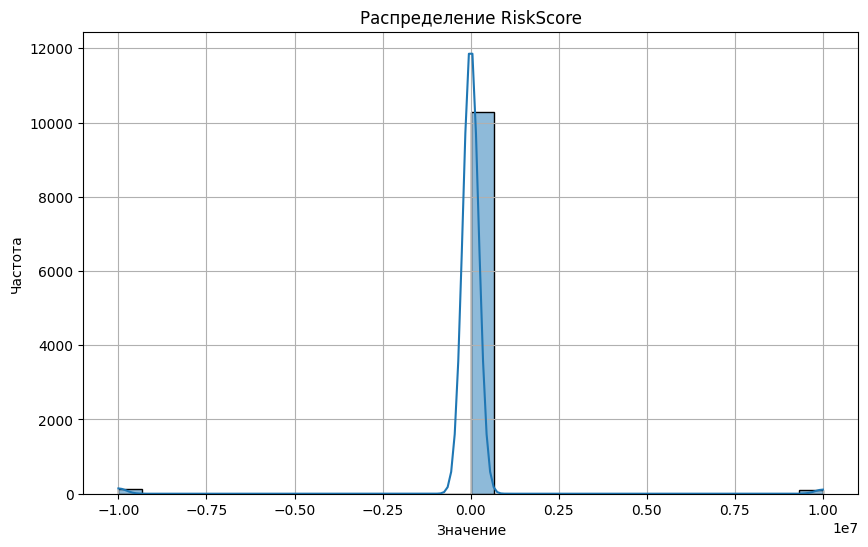

In [114]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='RiskScore', bins=30, kde=True)
plt.title('Распределение RiskScore')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [115]:
max_rs = data['RiskScore'].max()
min_rs = data['RiskScore'].min()
print(f'Максимальное значение RiskScore: {max_rs}')
print(f'Минимальное значение RiskScore: {min_rs}')

Максимальное значение RiskScore: 10000000.0
Минимальное значение RiskScore: -9999999.0


 ---
 ---
Ориентируясь на график, определим выбросы

In [116]:
print(len(data[data['RiskScore'] > 100]))
print(len(data[data['RiskScore'] == max_rs]))

94
94


In [117]:
print(len(data[data['RiskScore'] < 0]))
print(len(data[data['RiskScore'] == min_rs]))

121
121


 ---
 ---
Вне диапазона \[0; 100\] данные имеют одинаковые значения, считаем их выбросами

In [118]:
data = data[(data['RiskScore'] < 100) & (data['RiskScore'] > 0)]
len(data)

10272

## Корреляция признаков


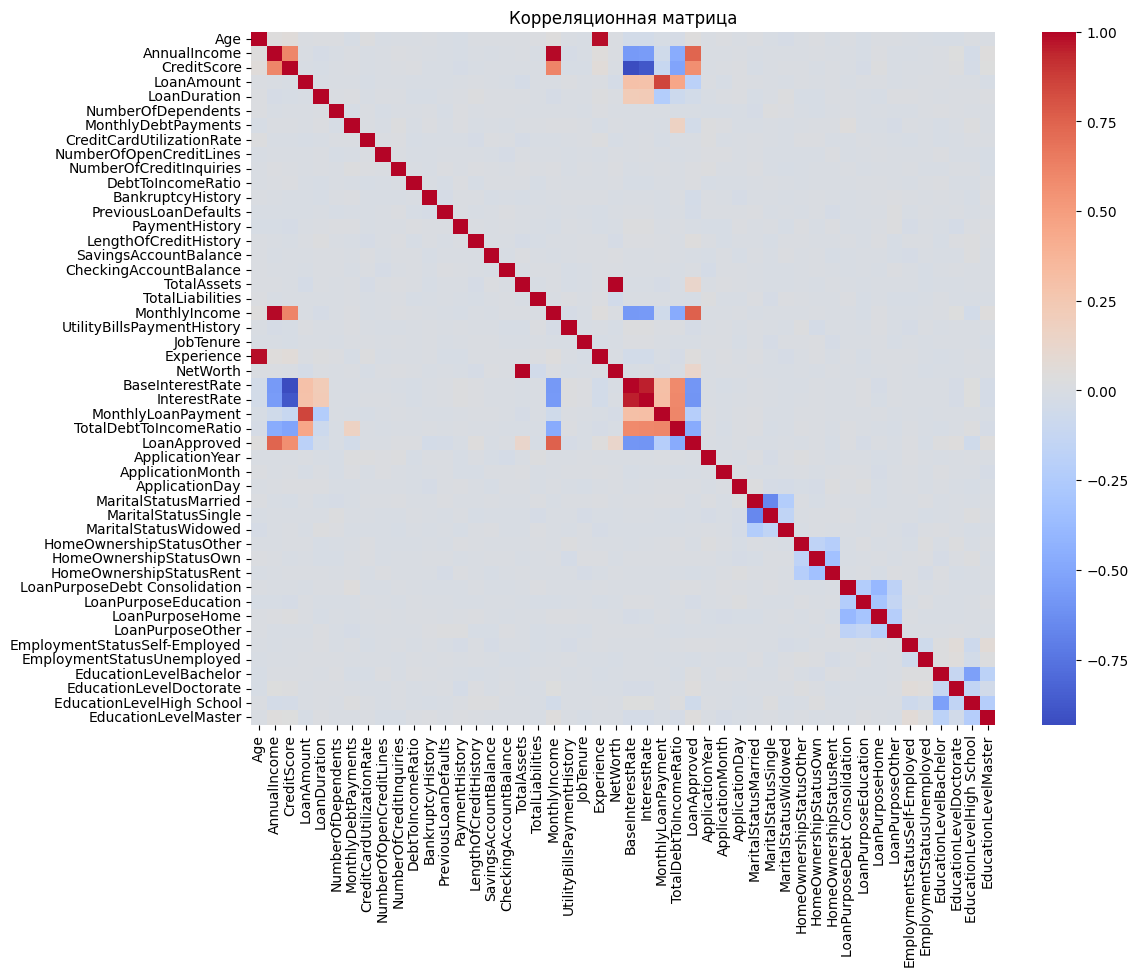

In [119]:
temp = data.drop(columns='RiskScore', errors='ignore')
data_cm = temp.corr()
plt.figure(figsize=(12,9))
sns.heatmap(data_cm, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Корреляционная матрица')
plt.show()

 Матрица корреляций признаков (без учета таргет-признака)

 ---
 ---

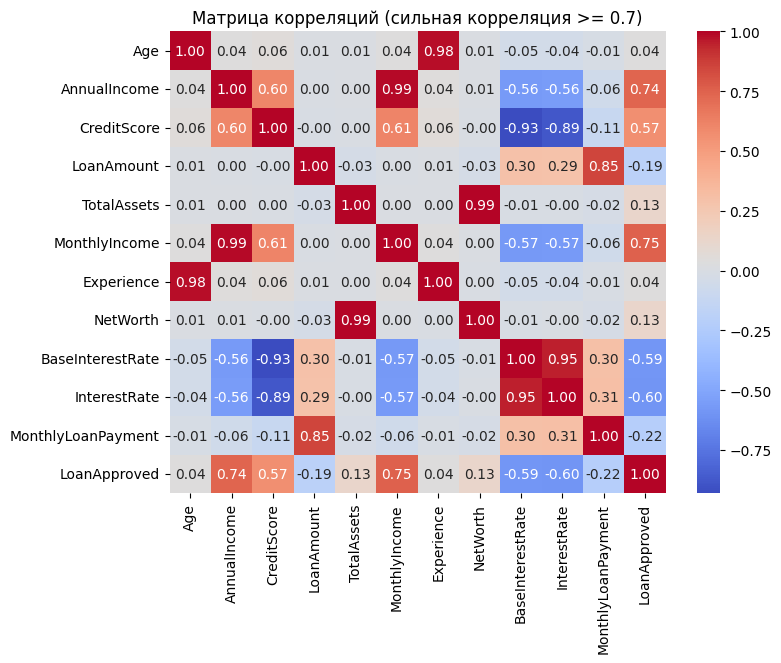

In [120]:
threshold = 0.7

columns = data_cm.columns

max_corr = np.empty(len(columns))

for i in range(0, len(columns)):
  tmp = data_cm[columns[i]].abs().values
  tmp = tmp[np.where(tmp < 1)]
  max_corr[i] = tmp.max()

weak_corr_columns = columns[np.where(max_corr < threshold)]

plt.figure(figsize=(8, 6))
sns.heatmap(temp.drop(columns=weak_corr_columns).corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title(f'Матрица корреляций (сильная корреляция >= {threshold})')
plt.show()

 Матрица сильной корреляций признаков (без учета таргет-признака)

 ---
 ---

## Проблема родственных признаков и ее решение


In [121]:
def show_dependency(df, xcol, ycol):
  corr_matrix = df[[xcol, ycol]].corr()
  x = df[xcol]
  y = df[ycol]
  p = np.poly1d(np.polyfit(x, y, 1))
  plt.scatter(x, y, alpha=0.5)
  plt.ylim(np.min(plt.yticks()[0]), np.max(plt.yticks()[0]))
  plt.plot(x, p(x), "r--")
  plt.scatter([], [], alpha=0, label=f'Корреляция: {corr_matrix[xcol][ycol]:.3f}')
  plt.xlabel(xcol)
  plt.ylabel(ycol)
  plt.title(f'Зависимость {ycol} от {xcol}')
  plt.grid(True)
  plt.legend()
  plt.show()

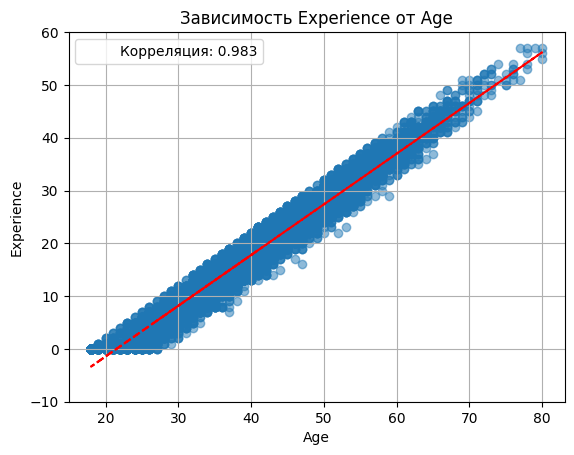

In [122]:
show_dependency(data, 'Age', 'Experience')

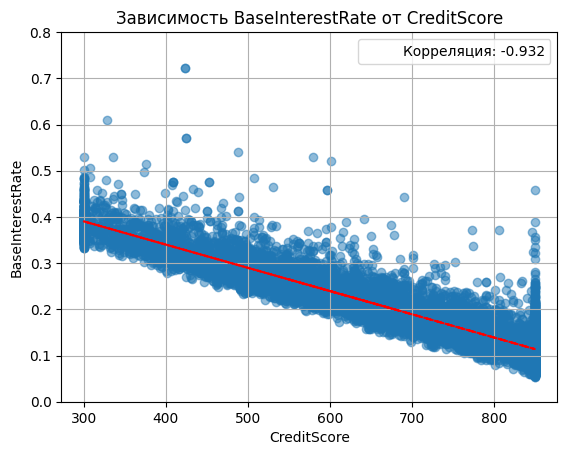

In [123]:
show_dependency(data, 'CreditScore', 'BaseInterestRate')

In [124]:
def show_heatmap(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f")
    plt.title('Матрица корреляции')
    plt.show()

 ---
 ---

Как видно из матрицы корреляций и графиков зависимости выше, в датасете есть родственные признаки. Можем избавиться от них. Со спокойной душой убираем признак с меньшей корреляцией с RiskScore.

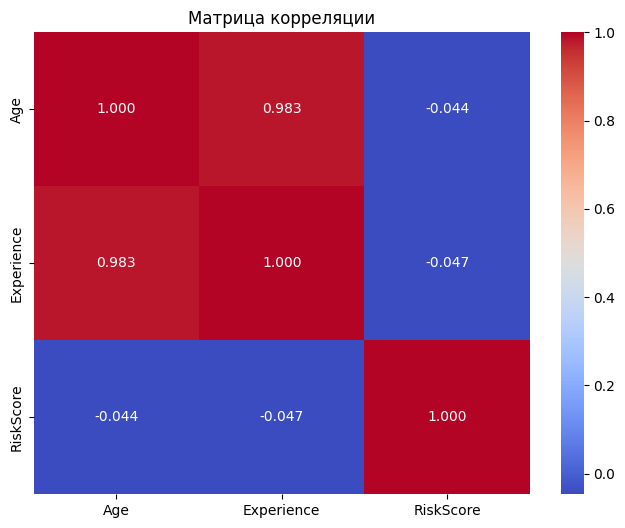

In [125]:
show_heatmap(data[['Age', 'Experience', 'RiskScore']])

In [126]:
data = data.drop('Age', axis=1)
testdata = testdata.drop('Age', axis=1)

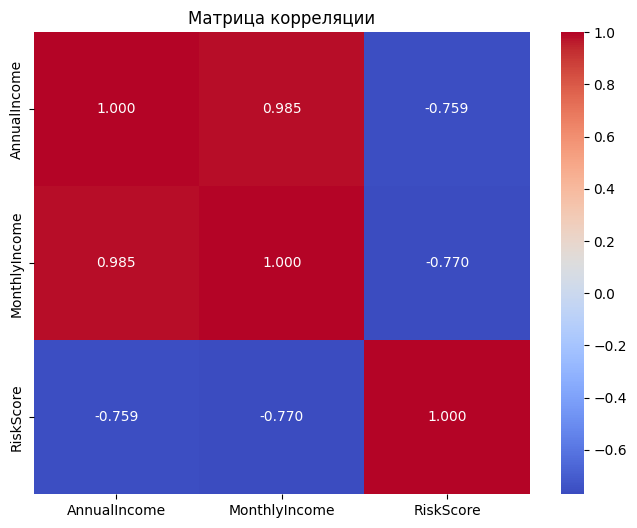

In [127]:
show_heatmap(data[['AnnualIncome', 'MonthlyIncome', 'RiskScore']])

In [128]:
data = data.drop('MonthlyIncome', axis=1)
testdata = testdata.drop('MonthlyIncome', axis=1)

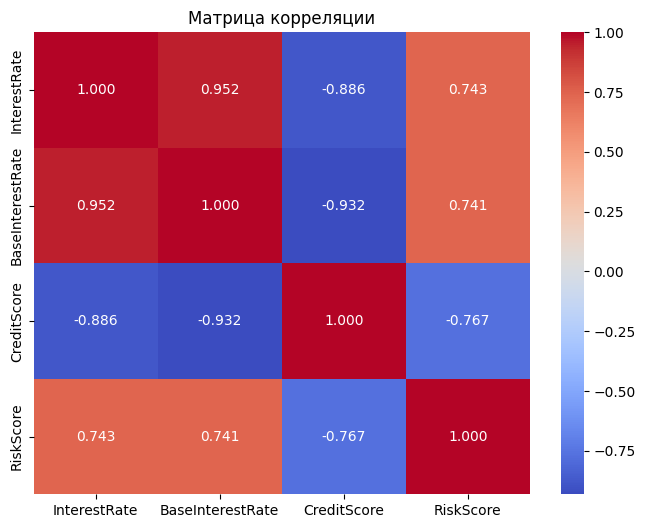

In [129]:
show_heatmap(data[['InterestRate', 'BaseInterestRate', 'CreditScore', 'RiskScore']])

 ---
 ---

В этой ситуации оставим CreditScore, так как он коррелирует с таргетом больше всего.

In [130]:
data = data.drop(columns=['BaseInterestRate'], axis=1)
testdata = testdata.drop(columns=['BaseInterestRate'], axis=1)

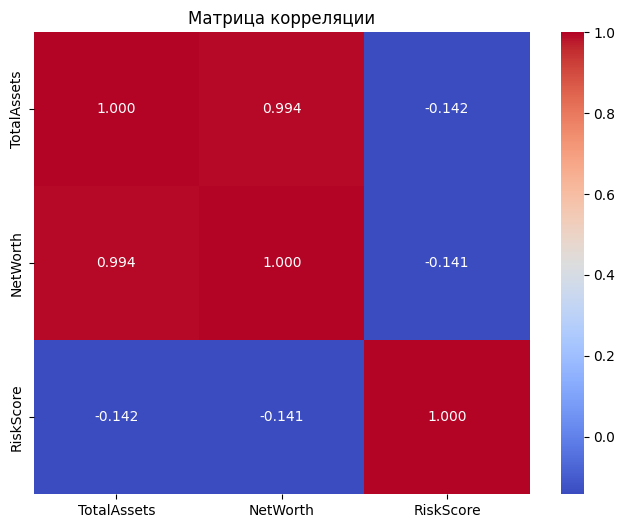

In [131]:
show_heatmap(data[['TotalAssets', 'NetWorth', 'RiskScore']])

In [132]:
data = data.drop('NetWorth', axis = 1)
testdata = testdata.drop('NetWorth', axis = 1)

## Логарифмическая нормализация

In [133]:
def check_normality(data: pd.DataFrame) -> pd.DataFrame:
    results = []

    for col in data.columns:
        x = data[col].values

        if len(x) > 8:
            _, p = normaltest(x)
            s = skew(x)
            k = kurtosis(x)

            results.append({
                'feature': col,
                'p_value': p,
                'skewness': s,
                'kurtosis': k,
                'sample_size': len(x)
            })

    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values('p_value', ascending=False)

    return df_results

features = data.drop(columns=['RiskScore'])
features = features.select_dtypes(include=np.number)
normality_results = check_normality(features)

print("Результаты проверки нормальности распределений:")
print(normality_results[['feature', 'p_value', 'skewness', 'kurtosis']])

Результаты проверки нормальности распределений:
                       feature        p_value   skewness    kurtosis
12              PaymentHistory   7.879397e-12   0.172462   -0.045915
20                  Experience   7.261713e-65   0.320065   -0.426558
19                   JobTenure   8.185493e-73   0.446744    0.234546
6    CreditCardUtilizationRate  6.966200e-115   0.587675   -0.168916
7      NumberOfOpenCreditLines  1.957693e-115   0.578543    0.305496
3                 LoanDuration  5.738168e-151   0.689213    0.237214
9            DebtToIncomeRatio  1.985855e-153   0.704175    0.127500
4           NumberOfDependents  8.071791e-157   0.714683   -0.099104
18  UtilityBillsPaymentHistory  6.062056e-174  -0.748216    0.283612
0                 AnnualIncome  8.761420e-176   0.669315   -0.470907
21                InterestRate  1.212841e-179   0.773373    0.165886
1                  CreditScore  1.689296e-232  -0.720998   -0.606457
8      NumberOfCreditInquiries  1.450963e-284   0.97321

 ---
 ---
Примеры симметричных и ассиметричных метрик

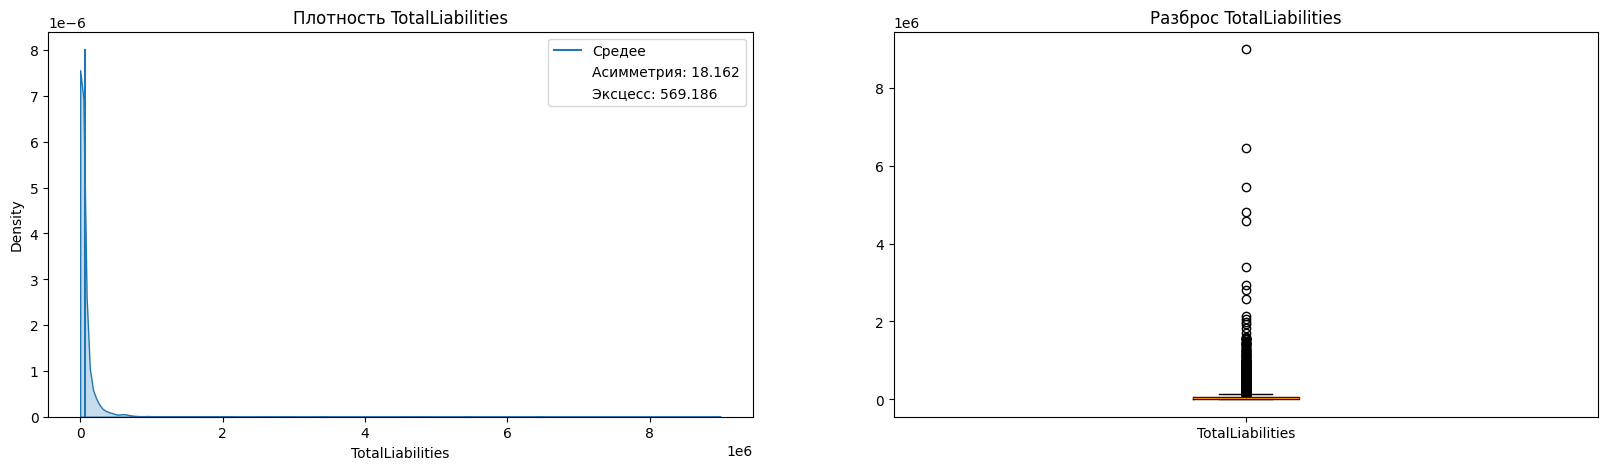

In [134]:
show_distribution(data, 'TotalLiabilities')

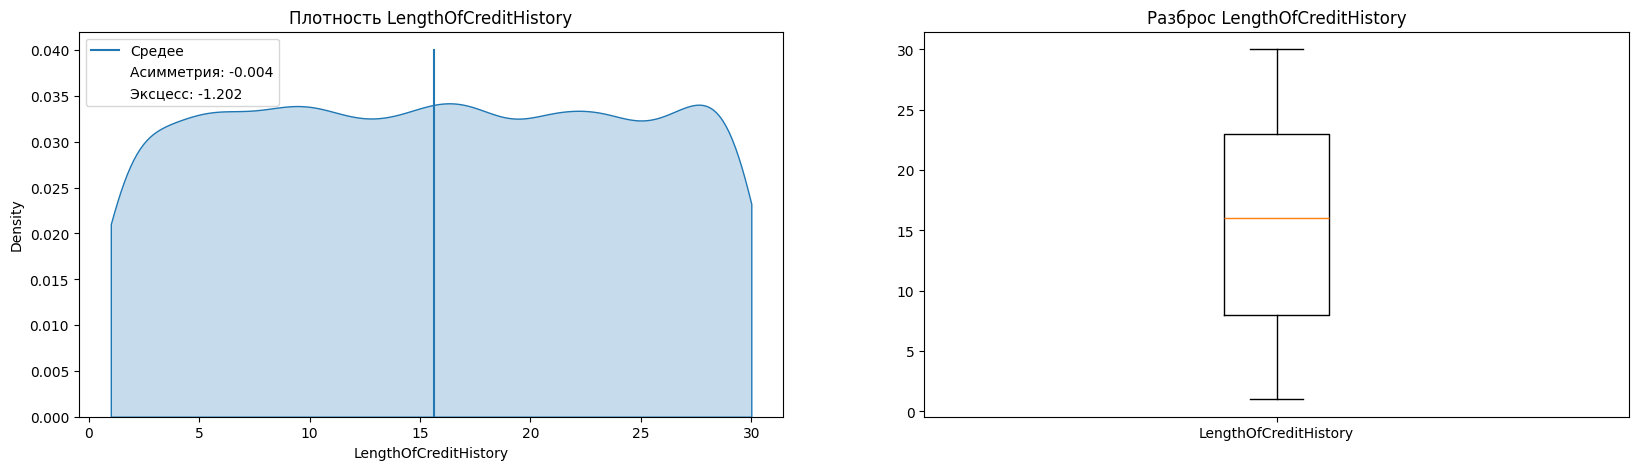

In [135]:
show_distribution(data, 'LengthOfCreditHistory')

 ---
 ---
Используем логарифмическое преобразование на ассиметричных метриках, пока не достигнем приемлимой симметрии

In [136]:
for i in range(3):
  for col in data.drop(columns=['RiskScore']).select_dtypes(include=np.number).columns:
      if skew(data[col]) > 0.5:
          data[f"log_{col}"] = np.log1p(data[col])
          data.drop(columns=[col], inplace=True)
          testdata[f"log_{col}"] = np.log1p(testdata[col])
          testdata.drop(columns=[col], inplace=True)

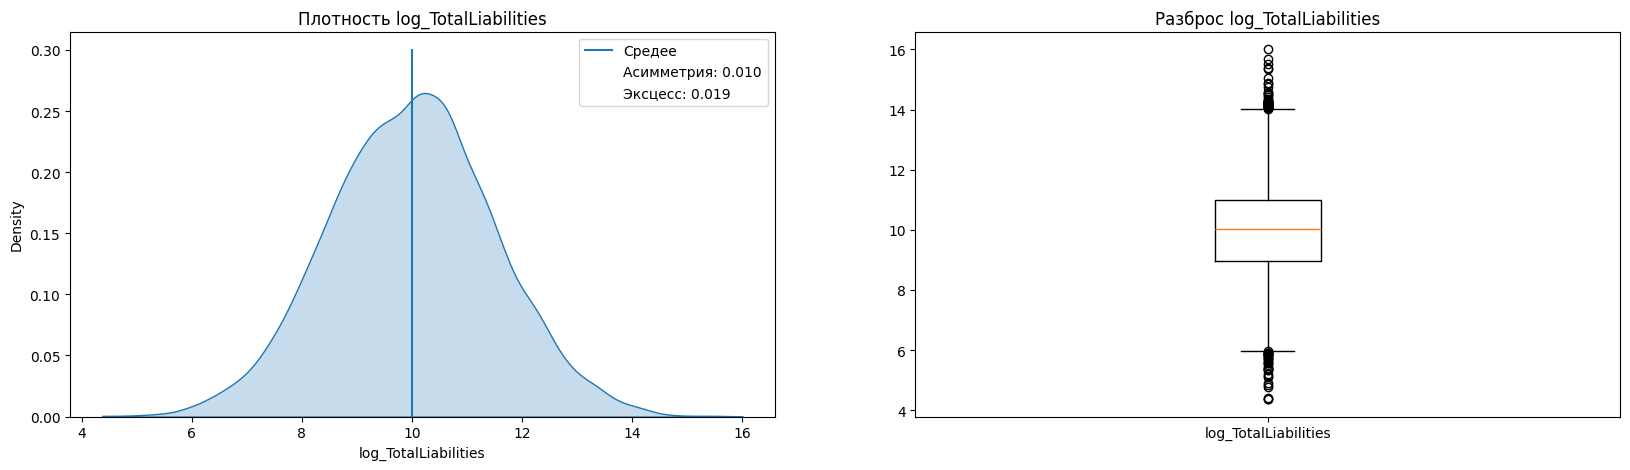

In [137]:
show_distribution(data, 'log_TotalLiabilities') # Логарифмированный параметр

## Z-Score

In [138]:
class ZScoreTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, with_mean=True, with_std=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.mean_ = None
        self.scale_ = None

    def fit(self, X, y=None):
        X = np.asarray(X)
        if self.with_mean:
            self.mean_ = np.mean(X, axis=0)
        else:
            self.mean_ = np.zeros(X.shape[1])

        if self.with_std:
            self.scale_ = np.std(X, axis=0)
            self.scale_[self.scale_ == 0] = 1.0
        else:
            self.scale_ = np.ones(X.shape[1])

        return self

    def transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise ValueError("Трансформер не обучен. Вызовите fit() сначала.")

        X = np.asarray(X)
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise ValueError("Трансформер не обучен. Вызовите fit() сначала.")

        X = np.asarray(X)
        return (X * self.scale_) + self.mean_

## MinMax

In [139]:
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_range=(0, 1), clip=False):
        self.feature_range = feature_range
        self.clip = clip

    def _reset(self):
        if hasattr(self, 'data_min_'):
            del self.data_min_
            del self.data_max_
            del self.data_range_
            del self.scale_
            del self.min_

    def fit(self, X, y=None):
        self._reset()
        X = np.asarray(X)

        if len(self.feature_range) != 2:
            raise ValueError("feature_range должен быть tuple (min, max).")
        if self.feature_range[0] >= self.feature_range[1]:
            raise ValueError("Min feature_range должен быть меньше max.")

        self.data_min_ = np.min(X, axis=0)
        self.data_max_ = np.max(X, axis=0)
        self.data_range_ = self.data_max_ - self.data_min_

        self.data_range_[self.data_range_ == 0] = 1.0

        self.scale_ = (self.feature_range[1] - self.feature_range[0]) / self.data_range_
        self.min_ = self.feature_range[0] - self.data_min_ * self.scale_

        return self

    def transform(self, X):
        check_is_fitted(self)
        X = np.asarray(X)

        X_scaled = X * self.scale_ + self.min_

        if self.clip:
            np.clip(X_scaled, self.feature_range[0], self.feature_range[1], out=X_scaled)

        return X_scaled

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        check_is_fitted(self)
        X = np.asarray(X)

        return (X - self.min_) / self.scale_

# Обучение модели

## Линейная регрессия

In [140]:
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import shuffle

class LinearRegression(BaseEstimator, RegressorMixin):


    # method : {'normal', 'gd', 'sgd'}, default='normal'
    def __init__(self, method='normal', learning_rate=0.01, batch_size=32,
                 max_iter=1000, tol=1e-4, fit_intercept=True, alpha=0.0,
                 random_state=None, verbose=0):
        self.method = method
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.tol = tol
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        self.random_state = random_state
        self.verbose = verbose

    def _prepare_data(self, X):
        if self.fit_intercept:
            X = np.hstack([np.ones((X.shape[0], 1)), X])
        return X

    def _loss(self, X, y, theta):
        m = len(y)
        error = X.dot(theta) - y
        loss = (1/(2*m)) * np.sum(error**2) + (self.alpha/(2*m)) * np.sum(theta[1:]**2)
        return loss

    def _gradient(self, X, y, theta):
        m = len(y)
        error = X.dot(theta) - y
        grad = (1/m) * X.T.dot(error)
        if self.alpha > 0:
            grad[1:] += (self.alpha/m) * theta[1:]
        return grad

    def _sgd_step(self, X, y, theta, indices):
        X_batch = X[indices]
        y_batch = y[indices]
        grad = self._gradient(X_batch, y_batch, theta)
        return theta - self.learning_rate * grad
        indices = np.random.permutation(n_samples)[:1]

    def fit(self, X, y):
        X, y = check_X_y(X, y, y_numeric=True)

        n_features = X.shape[1] + 1 if self.fit_intercept else X.shape[1]
        theta = np.zeros(n_features)
        X_prepared = self._prepare_data(X)
        self.loss_history_ = []

        if self.method == 'normal':
            if self.alpha == 0:
                theta = np.linalg.pinv(X_prepared.T.dot(X_prepared)).dot(X_prepared.T).dot(y)
            else:
                I = np.eye(X_prepared.shape[1])
                I[0, 0] = 0
                theta = np.linalg.pinv(X_prepared.T.dot(X_prepared) + self.alpha * I).dot(X_prepared.T).dot(y)
            self.n_iter_ = 1

        else:
            np.random.seed(self.random_state)
            n_samples = len(y)

            for i in range(self.max_iter):
                if self.method == 'gd':
                    theta = theta - self.learning_rate * self._gradient(X_prepared, y, theta)
                elif self.method == 'sgd':
                    indices = np.random.choice(n_samples, self.batch_size, replace=False)
                    theta = self._sgd_step(X_prepared, y, theta, indices)

                current_loss = self._loss(X_prepared, y, theta)
                self.loss_history_.append(current_loss)

                if self.verbose and i % 100 == 0:
                    print(f"Iter {i}: Loss = {current_loss:.4f}")

                if i > 0 and abs(self.loss_history_[-2] - current_loss) < self.tol:
                    break

            self.n_iter_ = i + 1

        if self.fit_intercept:
            self.intercept_ = theta[0]
            self.coef_ = theta[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = theta

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        X_prepared = self._prepare_data(X)
        return X_prepared.dot(np.concatenate([[self.intercept_], self.coef_]))

## Тестирование Линейной регрессии, сравнение с библиотечной реализацией

In [141]:
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=10, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = ZScoreTransformer()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

def evaluate_mse(model, X, y_true):
    y_pred = model.predict(X)
    return mean_squared_error(y_true, y_pred)

results = {}

sk_analytic = SkLinearRegression()
sk_analytic.fit(X_train, y_train)
results['SK Analytic'] = evaluate_mse(sk_analytic, X_test, y_test)

my_analytic = LinearRegression(method='normal')
my_analytic.fit(X_train, y_train)
results['Analytic'] = evaluate_mse(my_analytic, X_test, y_test)

my_gradient = LinearRegression(method='gd', learning_rate=0.01, max_iter=1000)
my_gradient.fit(X_train_norm, y_train)
results['Gradient'] = evaluate_mse(my_gradient, X_test_norm, y_test)

my_stochastic = LinearRegression(method='sgd', learning_rate=0.01, max_iter=1000)
my_stochastic.fit(X_train_norm, y_train)
results['Stochastic'] = evaluate_mse(my_stochastic, X_test_norm, y_test)

sgd_regressor = SGDRegressor(
    learning_rate='constant',
    eta0=0.01,
    max_iter=1000,
    tol=1e-4,
    random_state=512384
)
sgd_regressor.fit(X_train_norm, y_train)
results['SK Stochastic'] = evaluate_mse(sgd_regressor, X_test_norm, y_test)

print("{:<20} {:<15}".format('Method', 'MSE'))
print("-" * 35)
for name, mse in results.items():
    print("{:<20} {:.4f}".format(name, mse))

Method               MSE            
-----------------------------------
SK Analytic          0.0085
Analytic             0.0085
Gradient             0.0236
Stochastic           0.0312
SK Stochastic        0.0099


## Кросс-валидация

 ---
 ---

K-fold кросс-валидация

In [142]:
from sklearn.utils import check_random_state

class KFoldCV:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y=None):
        n_samples = len(X)
        indices = np.arange(n_samples)

        if self.shuffle:
            rng = check_random_state(self.random_state)
            rng.shuffle(indices)

        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1

        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_index = indices[start:stop]
            train_index = np.concatenate([indices[:start], indices[stop:]])
            yield train_index, test_index
            current = stop

    def get_n_splits(self, X=None, y=None):
        return self.n_splits

 ---
 ---

Leave-one-out кросс-валидация

In [143]:
class LeaveOneOutCV:

    def __init__(self):
        pass

    def split(self, X, y=None):
        n_samples = len(X)
        indices = np.arange(n_samples)

        for i in range(n_samples):
            test_index = np.array([i])
            train_index = np.delete(indices, i)
            yield train_index, test_index

    def get_n_splits(self, X=None, y=None):
        return len(X) if X is not None else 0

# Реализация и тест метрик

In [144]:
def mse_manual(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae_manual(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2_manual(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def mape_manual(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = np.array([3, -0.5, 2, 7])
y_pred = np.array([2.5, 0.0, 2, 8])

mse_custom = mse_manual(y_true, y_pred)
mae_custom = mae_manual(y_true, y_pred)
r2_custom = r2_manual(y_true, y_pred)
mape_custom = mape_manual(y_true, y_pred)

mse_sklearn = mean_squared_error(y_true, y_pred)
mae_sklearn = mean_absolute_error(y_true, y_pred)
r2_sklearn = r2_score(y_true, y_pred)

print("Результаты вычислений:")
print(f"MSE (вручную): {mse_custom}, MSE (sklearn): {mse_sklearn}")
print(f"MAE (вручную): {mae_custom}, MAE (sklearn): {mae_sklearn}")
print(f"R²  (вручную): {r2_custom}, R²  (sklearn): {r2_sklearn}")
print(f"MAPE (вручную): {mape_custom}")

Результаты вычислений:
MSE (вручную): 0.375, MSE (sklearn): 0.375
MAE (вручную): 0.5, MAE (sklearn): 0.5
R²  (вручную): 0.9486081370449679, R²  (sklearn): 0.9486081370449679
MAPE (вручную): 32.73809523809524


Значения совпадают -  реализация верная. Далее (для простоты) буду использовать реализации sklearn.

 ---
 ---

# Апогей


In [145]:
X, y = make_regression(n_samples=100, n_features=5, noise=0.1, random_state=42)

kfold = KFoldCV(n_splits=5, shuffle=True, random_state=42)
loo = LeaveOneOutCV()

def cross_val_score(estimator, X, y, cv, scoring=mean_squared_error):
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        scores.append(scoring(y_test, y_pred))

    return np.array(scores)

model = LinearRegression()
kfold_scores = cross_val_score(model, X, y, cv=kfold)
print(f"K-Fold MSE: {kfold_scores.mean():.4f} ± {kfold_scores.std():.4f}")

loo_scores = cross_val_score(model, X, y, cv=loo)
print(f"LOO MSE: {loo_scores.mean():.4f} ± {loo_scores.std():.4f}")

K-Fold MSE: 0.0094 ± 0.0012
LOO MSE: 0.0098 ± 0.0145


Почти совпадают, о как

---

In [146]:
x_train = data.drop(columns='RiskScore').values.astype(float)
y_train = data['RiskScore'].values.astype(float)
x_test = testdata.drop(columns='ID').values.astype(float)

methods = [
    ('Аналитически', 'normal'),
    ('Градиентный спуск', 'gd'),
    ('Стохастический градиентный спуск', 'sgd')
]

normalizations = [
    ('Z-score нормализация', ZScoreTransformer()),
    ('Min-Max нормализация', MinMaxTransformer())
]

def kfold_cross_validation(model, X, y, n_splits=5, random_state=None):
    kf = KFoldCV(n_splits=n_splits, shuffle=True, random_state=random_state)
    mse_scores = []
    r2_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    return {
        'MSE': {
            'mean': np.mean(mse_scores),
            'std': np.std(mse_scores)
        },
        'R2': {
            'mean': np.mean(r2_scores),
            'std': np.std(r2_scores)
        }
    }

for method_name, method_type in methods:
    print(f"\n{method_name}")
    print("=" * 50)

    for norm_name, scaler in normalizations:
        x_train_norm = scaler.fit_transform(x_train)
        x_test_norm = scaler.transform(x_test)

        model = LinearRegression(
            method=method_type,
            learning_rate=0.01 if method_type in ['gd', 'sgd'] else None,
            max_iter=1000 if method_type in ['gd', 'sgd'] else None,
        )

        cv_results = kfold_cross_validation(
            model,
            x_train_norm,
            y_train,
            random_state=42
        )

        model.fit(x_train_norm, y_train)
        y_pred = model.predict(x_test_norm)


        print(f"\n{norm_name}:")
        print("-" * 30)
        print("Кросс-валидация:")
        print(f"MSE: {cv_results['MSE']['mean']:.4f} ± {cv_results['MSE']['std']:.4f}")
        print(f"R2: {cv_results['R2']['mean']:.4f} ± {cv_results['R2']['std']:.4f}")


Аналитически

Z-score нормализация:
------------------------------
Кросс-валидация:
MSE: 17.7346 ± 0.3899
R2: 0.9403 ± 0.0023

Min-Max нормализация:
------------------------------
Кросс-валидация:
MSE: 17.7346 ± 0.3899
R2: 0.9403 ± 0.0023

Градиентный спуск

Z-score нормализация:
------------------------------
Кросс-валидация:
MSE: 17.8854 ± 0.3907
R2: 0.9398 ± 0.0023

Min-Max нормализация:
------------------------------
Кросс-валидация:
MSE: 47.3118 ± 0.8648
R2: 0.8406 ± 0.0056

Стохастический градиентный спуск

Z-score нормализация:
------------------------------
Кросс-валидация:
MSE: 18.9869 ± 1.1065
R2: 0.9360 ± 0.0049

Min-Max нормализация:
------------------------------
Кросс-валидация:
MSE: 51.9386 ± 4.3012
R2: 0.8249 ± 0.0177


## Формирование результата

In [150]:
model = LinearRegression(method='normal',learning_rate=None, max_iter=None)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

submission = pd.DataFrame({'ID': testdata['ID'], 'RiskScore': y_pred})
submission.to_csv('submission.csv', index=False)